# Naive Bayes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from utils import reduce_memory_usage, get_dataset_dtypes, derivate_features, get_model_metrics, k_fold_val, get_roc_curves
from sklearn import model_selection
from itertools import cycle
%matplotlib inline 

In [2]:
dtypes, numerical_columns, categorical_columns = get_dataset_dtypes()

In [3]:
path = 'train_preprocessed.csv'

In [4]:
df_train = pd.read_csv(path, dtype=dtypes, index_col=[0])

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df_train = df_train.sample(frac = 0.5)

In [6]:
print(f"Train dataset shape: {df_train.shape}")

Train dataset shape: (3833896, 67)


In [7]:
X_columns = ['AVProductsInstalled',
             'SmartScreen',
             'AVProductStatesIdentifier',
             'Census_OSArchitecture',
             'AppVersion_2',
             'Census_TotalPhysicalRAM',
             'IsProtected',
             'EngineVersion',
             'Census_SystemVolumeTotalCapacity',
             'CountryIdentifier',
             'OrganizationIdentifier',
             'AppVersion_3',
             'Census_FirmwareVersionIdentifier',
             'Census_ProcessorModelIdentifier',
             'Census_OEMModelIdentifier',
             'CountryIdentifier',
             'OrganizationIdentifier'
             ]


In [8]:
X = df_train[X_columns]
y = df_train["HasDetections"]
del df_train

In [9]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=31)

In [12]:
clf = GaussianNB()

In [13]:
clf.fit(x_train, y_train)

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(


GaussianNB()

## Metricas

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import label_binarize

In [15]:
y_pred= clf.predict(x_test)

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


In [16]:
conf_matrix = get_model_metrics(y_test, y_pred, 'Naive Bayes')


---Metrics for Naive Bayes---

 Confusion Matrix
 [[ 97301 285023]
 [ 57955 326501]]

 Accuracy 0.5527035133936722

 Precision 0.5801844529346413

 Recall 0.5527035133936722

 F1 Score 0.5092252374622711


## Curva ROC

In [17]:
 y_score = clf.predict_proba(x_test)

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


In [18]:
y_test.shape

(766780,)

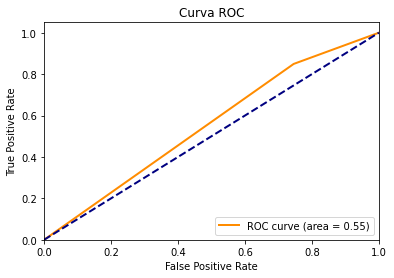

In [20]:
get_roc_curves(y_test,y_pred)

## K - folds

In [21]:
k_fold_val(clf, X, y, "Naive Bayes", splits = 10)

c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(
c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (ren

---k-fold scores for Naive Bayes---
Scores are:  [0.55459454 0.55372075 0.55368424 0.5535147  0.55192624 0.55327995
 0.55242587 0.5528771  0.55241543 0.55097825]
Mean is:  0.5529417065381595
STD is: +- 0.000988252111690594


## Haciendo Predicciones

In [ ]:
# TBD